In [9]:
import numpy as np
import matplotlib.pyplot as plt
import pylab
from pycbc import frame
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.waveform import get_fd_waveform, get_td_waveform
from pycbc.filter import highpass_fir, matched_filter, match
from pycbc.vetoes import power_chisq_bins, power_chisq
from pycbc.events import newsnr
%matplotlib inline

import style
plt.style.use(style.style1)

In [10]:
hstrain = frame.read_frame('../Data/H-H1_LOSC_4_V1-1126076416-4096.gwf', 'H1:LOSC-STRAIN')
lstrain = frame.read_frame('../Data/L-L1_LOSC_4_V1-1126076416-4096.gwf', 'L1:LOSC-STRAIN')

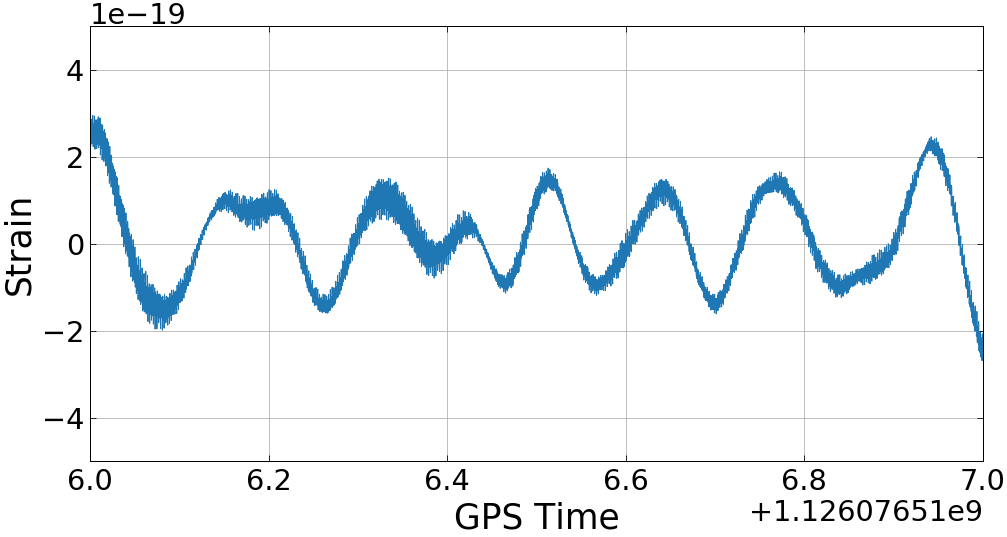

In [11]:
plt.figure(figsize=(16, 8))
plt.plot(hstrain.sample_times, hstrain)
plt.xlim([hstrain.sample_times[0] + 100, hstrain.sample_times[0] + 101])
plt.ylim([-0.5*10**-18, 0.5*10**-18])
plt.xlabel('GPS Time')
plt.ylabel('Strain')
plt.grid()
plt.savefig('strain.png')

In [12]:
hp, hc = get_td_waveform(approximant="IMRPhenomD", mass1=20, mass2=20, delta_t=hstrain.delta_t, f_lower=30, distance = 1500)
fp, fc = get_fd_waveform(approximant="IMRPhenomD", mass1=20, mass2=20, delta_f=hstrain.delta_f, f_lower=30, distance = 1500)
pp = np.abs(fp*np.conj(fp))

temp = hp.copy()
temp.resize(len(hstrain))
temp = temp.cyclic_time_shift(temp.start_time)

hstrain += temp.cyclic_time_shift(32).numpy()
hwhite = hstrain.whiten(4, 4)

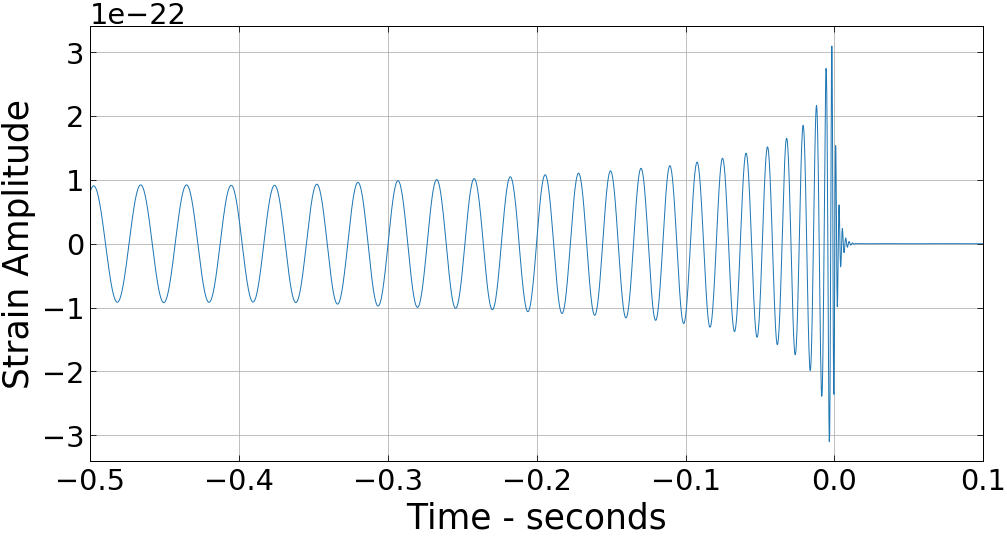

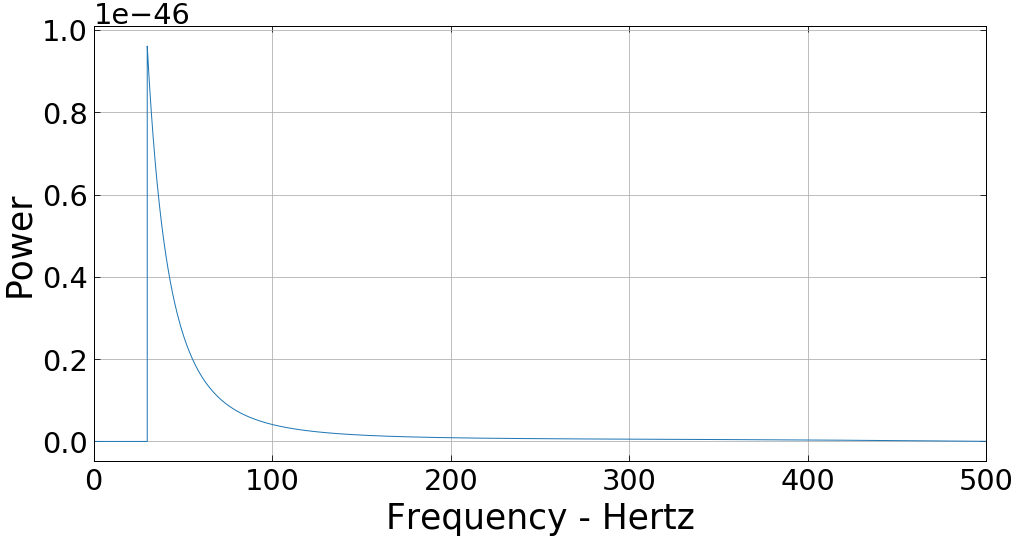

In [13]:
plt.figure(figsize=(16, 8))
plt.plot(hp.sample_times, hp)
plt.xlim([-0.5, 0.1])
plt.xlabel('Time - seconds')
plt.ylabel('Strain Amplitude')
plt.grid()
plt.savefig('wave.png')

plt.figure(figsize=(16, 8))
plt.plot(pp.sample_frequencies, pp)
plt.xlim([fp.sample_frequencies[0], 500])
plt.xlabel('Frequency - Hertz')
plt.ylabel('Power')
plt.grid()
plt.savefig('freq.png')

In [14]:
hpsd = hstrain.psd(4)
lpsd = lstrain.psd(4)

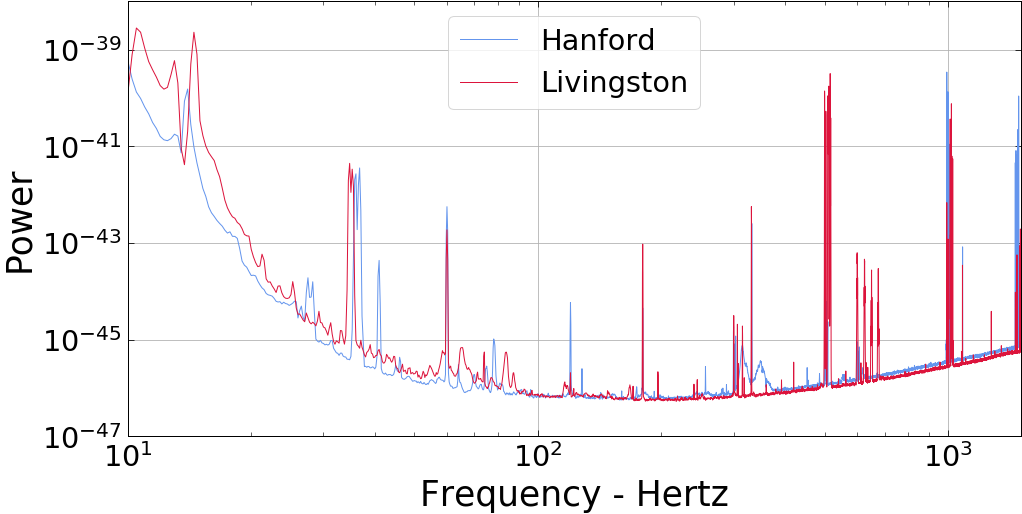

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(hpsd.sample_frequencies, hpsd, label='Hanford', c='cornflowerblue')
plt.xscale('log')
plt.yscale('log')
plt.xlim([10, 1500])
plt.ylim([1e-47, 1e-38])
plt.xlabel('Frequency - Hertz')
plt.ylabel('Power')
plt.grid()
plt.savefig('psd_single.png')

plt.plot(lpsd.sample_frequencies, lpsd, label='Livingston', c='crimson')
plt.legend()
plt.savefig('psd_two.png')

In [16]:
gt = hwhite.sample_times[np.argmax(np.abs(hwhite.numpy()))]
gi = np.argmax(hwhite.sample_times > gt)

st = hstrain.sample_times[32*hstrain.sample_rate]
si = np.argmax(hwhite.sample_times > st)

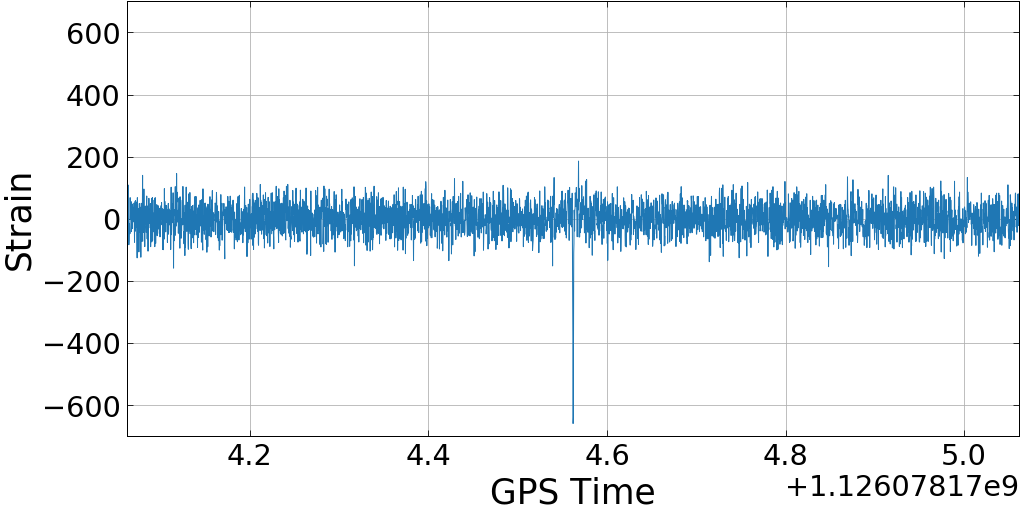

In [17]:
plt.figure(figsize=(16, 8))
plt.plot(hwhite.sample_times, hwhite)
plt.ylim([-700, 700])
plt.xlabel('GPS Time')
plt.ylabel('Strain')
plt.grid()
plt.xlim([hstrain.sample_times[0] + 100, hstrain.sample_times[0] + 101])
plt.savefig('white.png')

plt.xlim([st - 0.5, st + 0.5])
plt.savefig('cbc.png')

plt.xlim([gt - 0.5, gt + 0.5])
plt.savefig('glitch.png')

In [18]:
qt, qf, qq = hwhite[hwhite.sample_rate*100:hwhite.sample_rate*102].qtransform(hp.delta_t, logfsteps=500, frange=(30, 1000))
gtq, gfq, gq = hwhite[gi-int(hwhite.sample_rate*1):gi+int(hwhite.sample_rate*1)].qtransform(hp.delta_t, logfsteps=500, frange=(30, 1000))
stq, sfq, sq = hwhite[si-int(hwhite.sample_rate*1):si+int(hwhite.sample_rate*1)].qtransform(hp.delta_t, logfsteps=500, frange=(30, 1000))

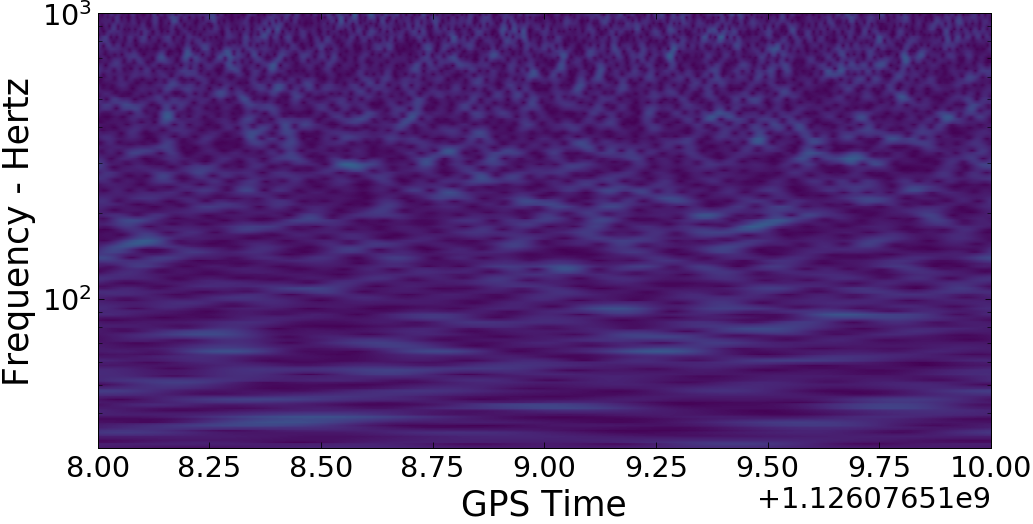

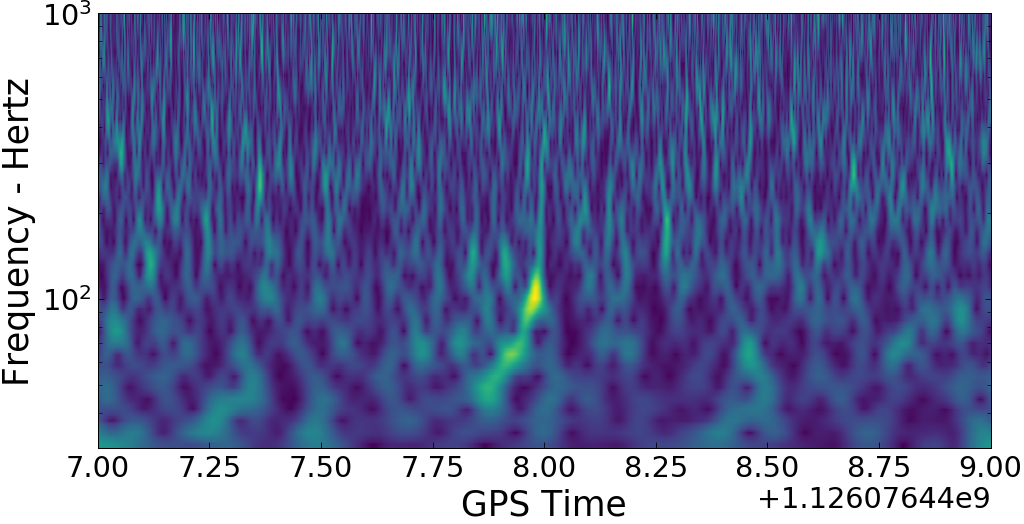

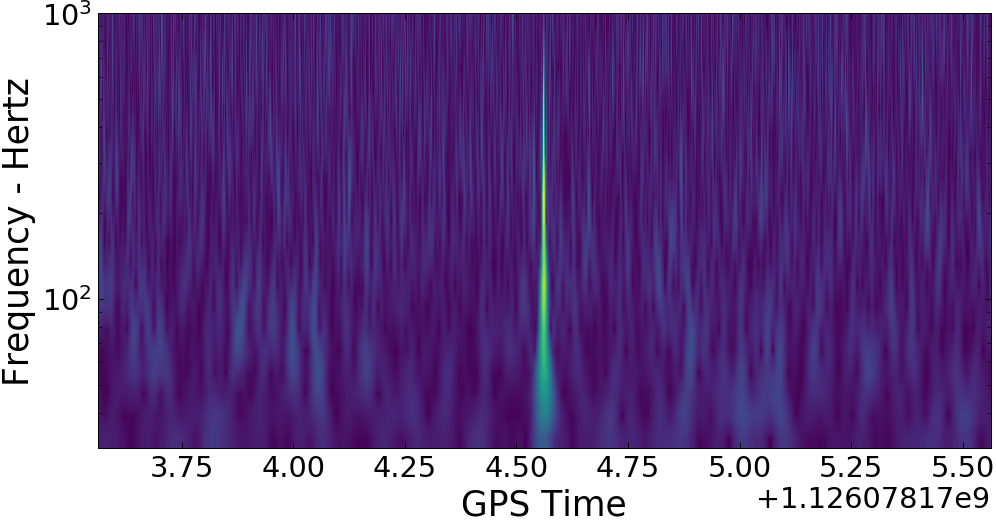

In [19]:
plt.figure(figsize=(16, 8))
plt.xlabel('GPS Time')
plt.ylabel('Frequency - Hertz')
pylab.pcolormesh(qt, qf, qq**0.5, vmin=0, vmax=np.max(gq**0.5))
pylab.yscale('log')
plt.savefig('white_q.png')

plt.figure(figsize=(16, 8))
plt.xlabel('GPS Time')
plt.ylabel('Frequency - Hertz')
pylab.pcolormesh(stq, sfq, sq**0.5)
pylab.yscale('log')
plt.savefig('cbc_q.png')

plt.figure(figsize=(16, 8))
plt.xlabel('GPS Time')
plt.ylabel('Frequency - Hertz')
pylab.pcolormesh(gtq, gfq, gq**0.5, vmin=0, vmax=np.max(gq**0.5))
pylab.yscale('log')
plt.savefig('glitch_q.png')

In [20]:
hpsd = interpolate(hpsd, hstrain.delta_f)
hpsd = inverse_spectrum_truncation(hpsd, hstrain.sample_rate * 4, low_frequency_cutoff=15)

snr = np.abs(matched_filter(temp, hstrain, psd=hpsd, low_frequency_cutoff=20))

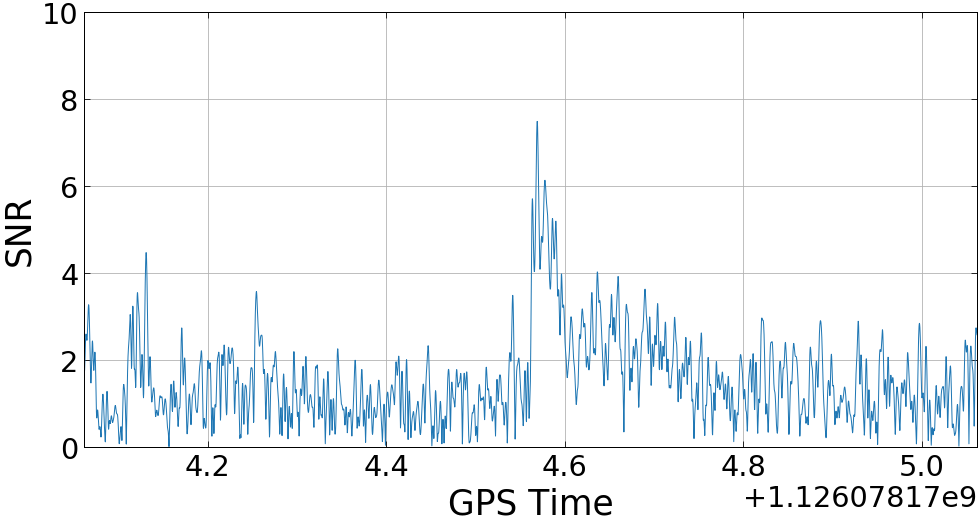

In [21]:
plt.figure(figsize=(16, 8))
plt.plot(snr.sample_times, snr)
plt.xlim([hstrain.sample_times[0] + 100, hstrain.sample_times[0] + 101])
plt.ylim([0, 10])
plt.xlabel('GPS Time')
plt.ylabel('SNR')
plt.grid()
plt.savefig('white_snr.png')

plt.xlim([st - 0.5, st + 0.5])
plt.savefig('cbc_snr.png')

plt.xlim([gt - 0.5, gt + 0.5])
plt.savefig('glitch_snr.png')

In [22]:
nbins = 3
tf = temp.to_frequencyseries()
bins = power_chisq_bins(tf, nbins, hpsd, low_frequency_cutoff=20)
print(bins)

[  81920  228963  426682 8388608]


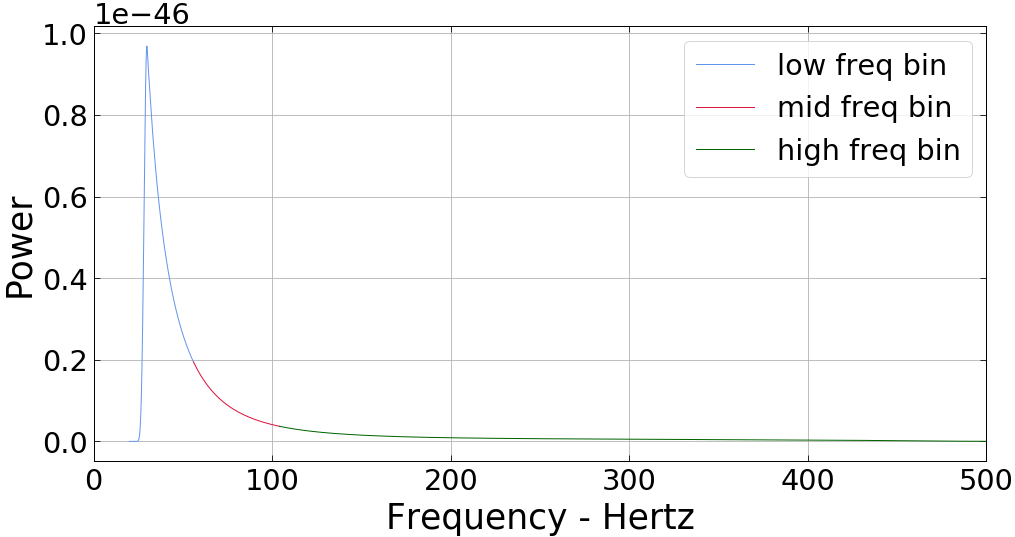

In [23]:
c = ['cornflowerblue', 'crimson', 'darkgreen']
l = ['low freq bin', 'mid freq bin', 'high freq bin']
plt.figure(figsize=[16, 8])
for i in range(nbins):
    pf = tf[bins[i]:bins[i+1]]
    plt.plot(tf.sample_frequencies[bins[i]:bins[i+1]], np.abs(pf*np.conj(pf)), c=c[i], label=l[i])
    plt.xlim([0, 500])
    plt.xlabel('Frequency - Hertz')
    plt.ylabel('Power')
    plt.grid()
plt.legend()
plt.savefig('bins.png')

In [24]:
chi, bsnr = power_chisq(temp, hstrain, nbins, hpsd, low_frequency_cutoff=20, return_bins=True)

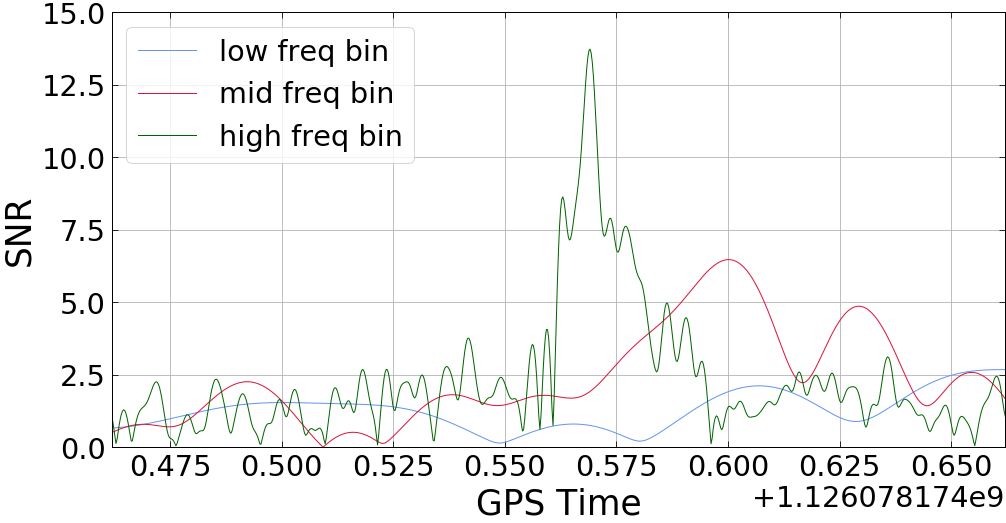

In [25]:
plt.figure(figsize=[16, 8])
for i in range(nbins):
    plt.plot(bsnr[i].sample_times, np.abs(bsnr[i]), c=c[i], label=l[i])
plt.xlabel('GPS Time')
plt.ylabel('SNR')
plt.grid()
plt.legend(loc='upper left')
plt.xlim([st - 0.1, st + 0.1])
plt.ylim(0, 15)
plt.savefig('cbc_bins.png')

plt.xlim([gt - 0.1, gt + 0.1])
plt.savefig('glitch_bins.png')

In [26]:
gin = np.argmax(snr.sample_times > gt)
sin = np.argmax(snr.sample_times > st)

newsnrg = newsnr(snr[gin-int(hwhite.sample_rate*1):gin+int(hwhite.sample_rate*1)],
                 chi[gin-int(hwhite.sample_rate*1):gin+int(hwhite.sample_rate*1)],
                 q=nbins)

newsnrs = newsnr(snr[sin-int(hwhite.sample_rate*1):sin+int(hwhite.sample_rate*1)],
                 chi[sin-int(hwhite.sample_rate*1):sin+int(hwhite.sample_rate*1)],
                 q=nbins)

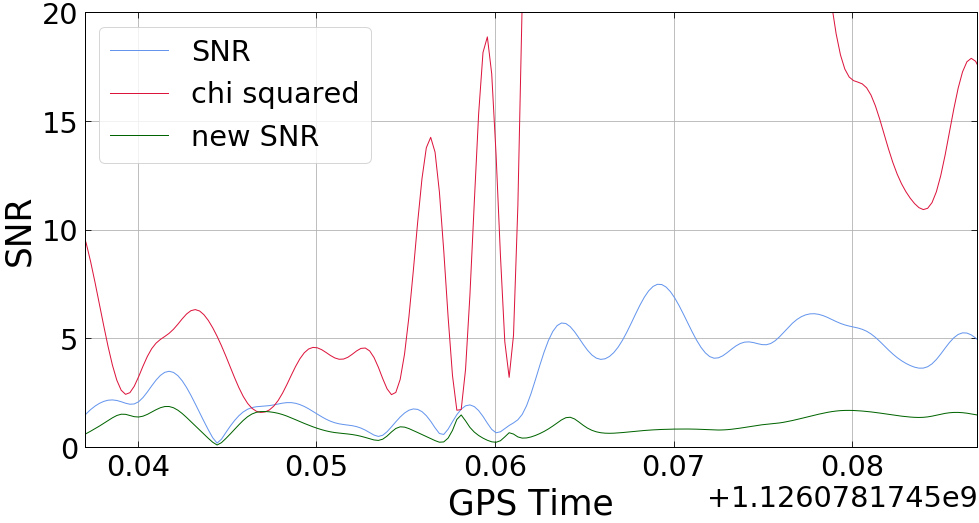

In [27]:
plt.figure(figsize=(16, 8))
plt.plot(snr.sample_times, snr, label='SNR', c='cornflowerblue')
plt.plot(chi.sample_times, chi, label='chi squared', c='crimson')
plt.plot(snr.sample_times[gin-int(hwhite.sample_rate*1):gin+int(hwhite.sample_rate*1)], newsnrg, label='new SNR', c='darkgreen')
plt.plot(snr.sample_times[sin-int(hwhite.sample_rate*1):sin+int(hwhite.sample_rate*1)], newsnrs, c='darkgreen')
plt.xlabel('GPS Time')
plt.ylabel('SNR')
plt.grid()
plt.legend(loc='upper left')
plt.ylim([0, 20])
plt.xlim([st - 0.025, st + 0.025])
plt.savefig('cbc_new.png')

plt.xlim([gt - 0.025, gt + 0.025])
plt.savefig('glitch_new.png')